# Lesson 13 Homework
#### EDA, Random Forests, Text Classification
---

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 30)

# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = False
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

## Introduction

Rotten Tomatoes gathers movie reviews from critics. An [entry on the website](http://www.rottentomatoes.com/m/primer/reviews/?type=top_critics) typically consists of a short quote, a link to the full review, and a Fresh/Rotten classification which summarizes whether the critic liked/disliked the movie.


When critics give quantitative ratings (say 3/4 stars, Thumbs up, etc.), determining the Fresh/Rotten classification is easy. However, publications like the New York Times don't assign numerical ratings to movies, and thus the Fresh/Rotten classification must be inferred from the text of the review itself.

This basic task of categorizing text has many applications. All of the following questions boil down to text classification:

 * Is a movie review positive or negative?
 * Is an email spam, or not?
 * Is a comment on a blog discussion board appropriate, or not?
 * Is a tweet about your company positive, or not?
 

Language is incredibly nuanced, and there is an entire field of computer science dedicated to the topic (Natural Language Processing). Nevertheless, we can construct basic language models using fairly straightforward techniques. 

## The Data

You will be starting with a database of Movies, derived from the MovieLens dataset. This dataset includes information for about 10,000 movies, including the IMDB id for each movie.

In [2]:
# pull in the data set
critics = pd.read_csv('critics.csv')

#for this assignment, let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]

In [3]:
critics.fresh.unique()

array(['fresh', 'rotten', 'none'], dtype=object)

In [4]:
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


## Exploratory Data Analysis

#### How many reviews, critics, and movies are there in this data set?

In [5]:
number_reviews = len(critics) 
number_critics = len(critics.critic.unique())
number_movies = len(critics.rtid.unique())

print "Number of reviews: %i" % number_reviews
print "Number of critics: %i" % number_critics
print "Number of movies:  %i" % number_movies

Number of reviews: 15624
Number of critics: 623
Number of movies:  1930


#### What does the distribution of number of reviews per reviewer look like? Make a histogram

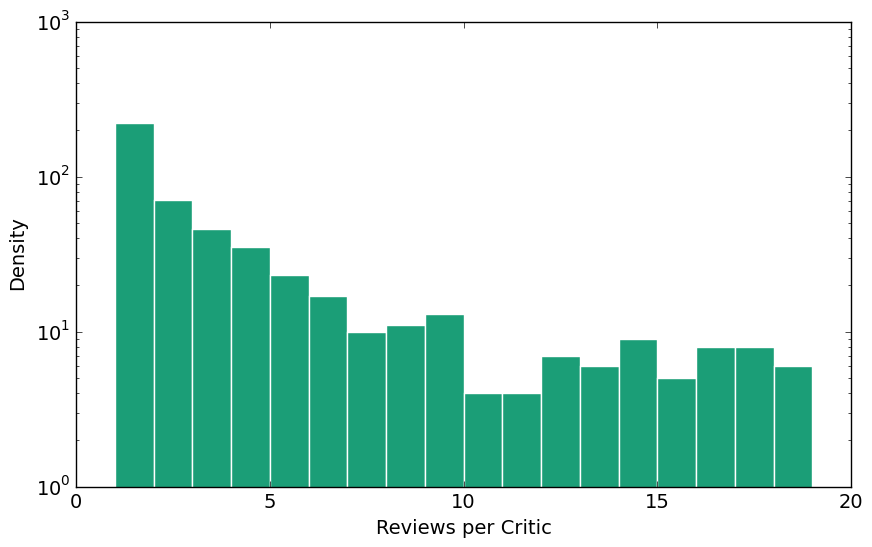

In [6]:
critic_review = critics.groupby('critic').rtid.count()

plt.hist(critic_review,log=True,bins=range(20), edgecolor='white')
plt.xlabel("Reviews per Critic")
plt.ylabel("Density")

#### List the 5 critics with the most reviews, along with the publication they write for hint: use `.goupby()` and `.count()`

In [7]:
critic_publication = critics.groupby(['critic', 'publication']).critic.count()
critic_publication.sort(ascending=False)
critic_publication.head()

critic              publication      
Roger Ebert         Chicago Sun-Times    1078
James Berardinelli  ReelViews             807
Janet Maslin        New York Times        518
Variety Staff       Variety               434
Jonathan Rosenbaum  Chicago Reader        413
Name: critic, dtype: int64

#### Of the critics with > 100 reviews, plot the distribution of "fresh" rating proportions per critic

In [8]:
critics['fresh_binary'] = np.where(critics['fresh'] == 'fresh',1,0)
critic_fresh = critics.groupby(['critic']).fresh_binary.agg(['mean','count'])
critic_fresh_100 = critic_fresh[critic_fresh['count'] > 100]

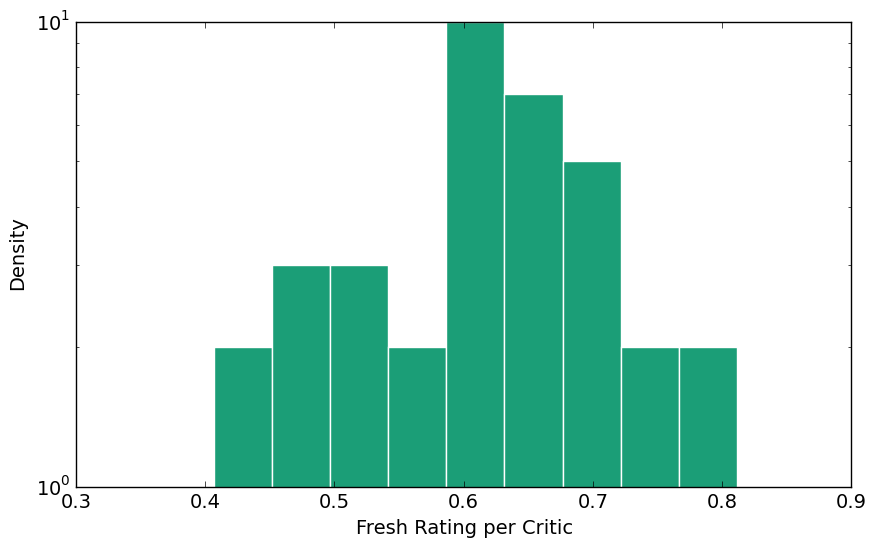

In [9]:
plt.hist(critic_fresh_100['mean'],log=True,bins=10, edgecolor='white')
plt.xlabel("Fresh Rating per Critic")
plt.ylabel("Density")

#### Plot the "fresh" rating proportions as a function of year. Overplot the average for each year. Comment on the result -- is there a trend? What do you think it means?

In [10]:
critics['year'] = critics['review_date'].str[:4].astype(int)
critic_year_fresh = critics.groupby(['year'],as_index=False).fresh_binary.mean()
# see only past 20 years
critic_year_fresh.head()

,year,fresh_binary
0,1800,1
1,1929,0
2,1930,1
3,1932,1
4,1933,1


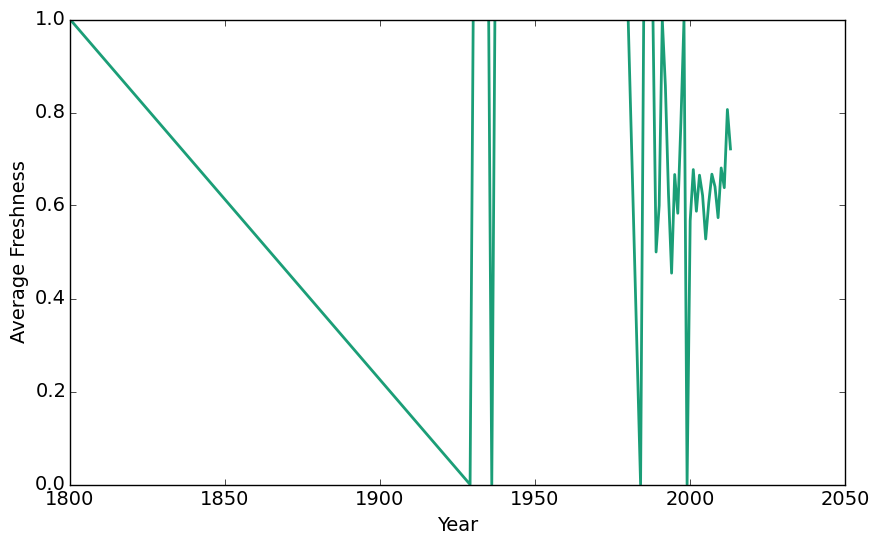

In [11]:
plt.plot(critic_year_fresh.year, critic_year_fresh.fresh_binary)
plt.xlabel('Year')
plt.ylabel('Average Freshness')

# this looks bizarre... let's zoom into 20 years out

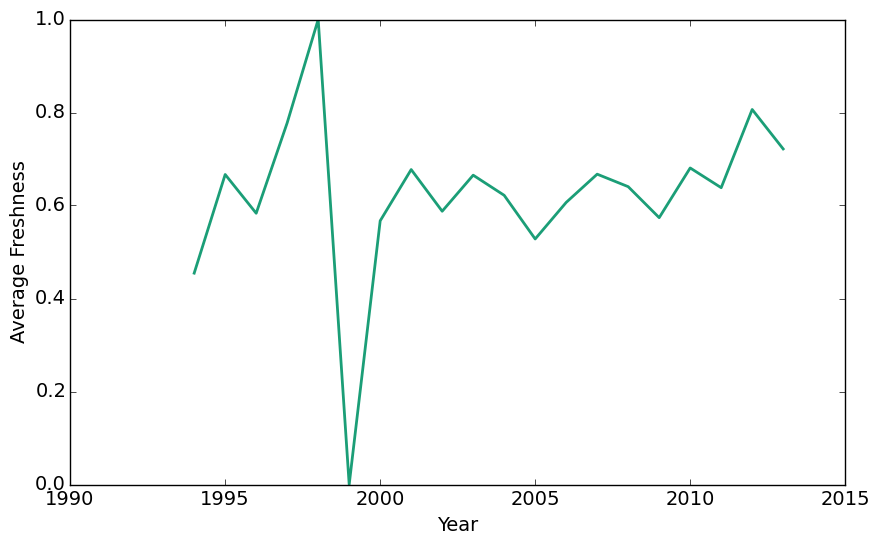

In [12]:
# see only past 20 years
critic_year_fresh = critics.groupby(['year'],as_index=False).fresh_binary.mean().iloc[-20:]

plt.plot(critic_year_fresh.year, critic_year_fresh.fresh_binary)
plt.xlabel('Year')
plt.ylabel('Average Freshness')

# what happened in 1999?!

## Prediction  
In class we learned about how to transform text data using the `CountVectorizer` and `TfidfVectorizer` functions from `sklearn`. Your job is to transform the critic review text into data to be used in a random forest model. Train a random forest model with your transformed data and run cross validation to see what the model fit is like

#### Write a function to transform the review text into data for a random forest model

In [13]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = CountVectorizer(max_df=0.85,
                             min_df=5,
                             ngram_range=[1, 2], 
                             stop_words='english'
#                             , binary=True
                            )

# Use `fit` to learn the vocabulary of the quotes
vectorizer.fit(critics.quote)

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.85, max_features=None, min_df=5,
        ngram_range=[1, 2], preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

#### Fit a random forest model on your transformed data

In [14]:
from sklearn.ensemble import RandomForestClassifier

# random forest model using 20 decision trees
model = RandomForestClassifier(n_estimators = 20)

# Use `tranform` to generate the sample X word matrix - one column per feature (word or n-grams)
x = vectorizer.transform(critics.quote).todense()
y = critics['fresh_binary']

model.fit(x,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#### Run cross validation on your model and determine the best parameters  
Try modifying the inputs to the `CountVectorizer` or `TfidfVectorizer` models and the `RandomForestClassifier` model

In [15]:
from sklearn.cross_validation import cross_val_score

scores = cross_val_score(model, x, y, scoring='roc_auc')
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

CV AUC [ 0.74124807  0.72760324  0.74394065], Average AUC 0.737597320024


#### Identify the most important features in your model

In [16]:
all_feature_names = vectorizer.get_feature_names()
feature_importances = pd.DataFrame({'Features' : all_feature_names, 'Importance Score': model.feature_importances_})
feature_importances.sort('Importance Score', ascending=False).head()

,Features,Importance Score
585,best,0.004341
471,bad,0.004271
2295,film,0.004258
1984,entertaining,0.004033
4099,movie,0.003727
